In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [2]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
from scipy.stats import mode

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

In [3]:
# Hàm xử lý một file parquet (từ dữ liệu actigraphy)
def process_file(filename, dirname):
    file_path = os.path.join(dirname, filename, 'part-0.parquet')
    df = pd.read_parquet(file_path)
    df.drop('step', axis=1, inplace=True)

    # Optimize memory usage by downcasting numerical columns
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    # Return statistics and id from the filename
    return df.describe().values.reshape(-1), filename.split('=')[1]

In [4]:

def load_time_series(dirname):
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes

    return df

In [5]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

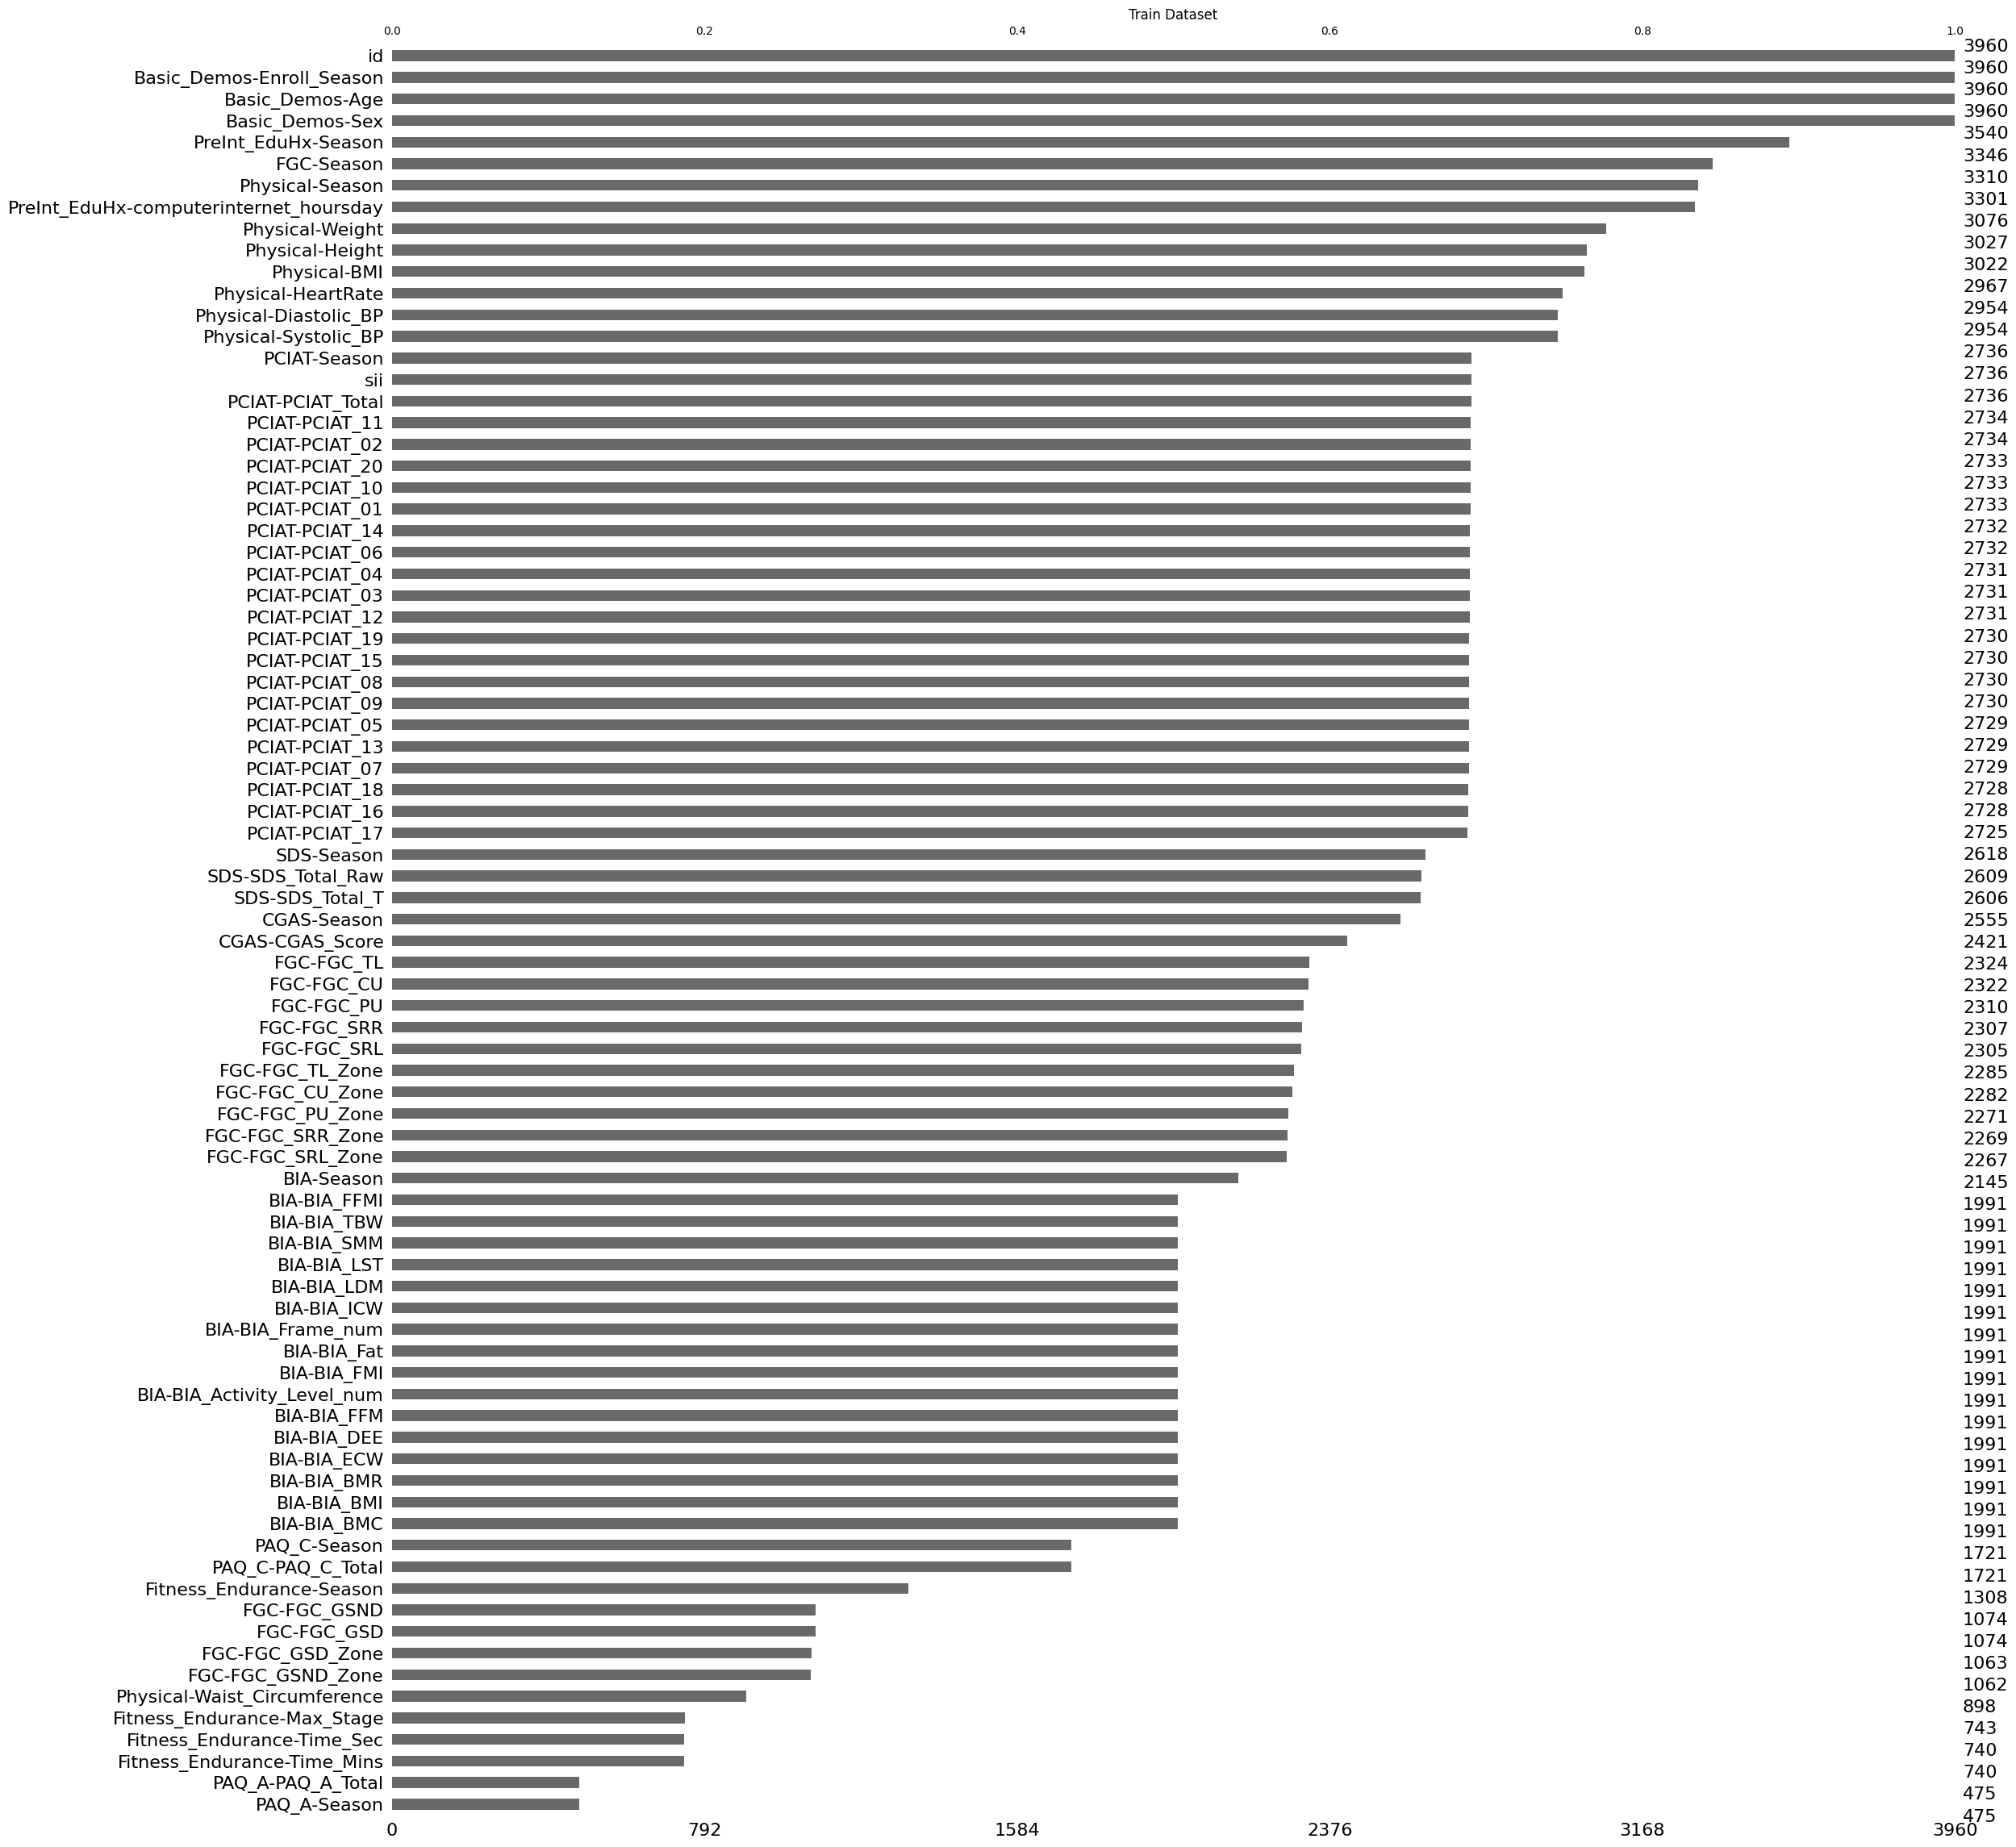

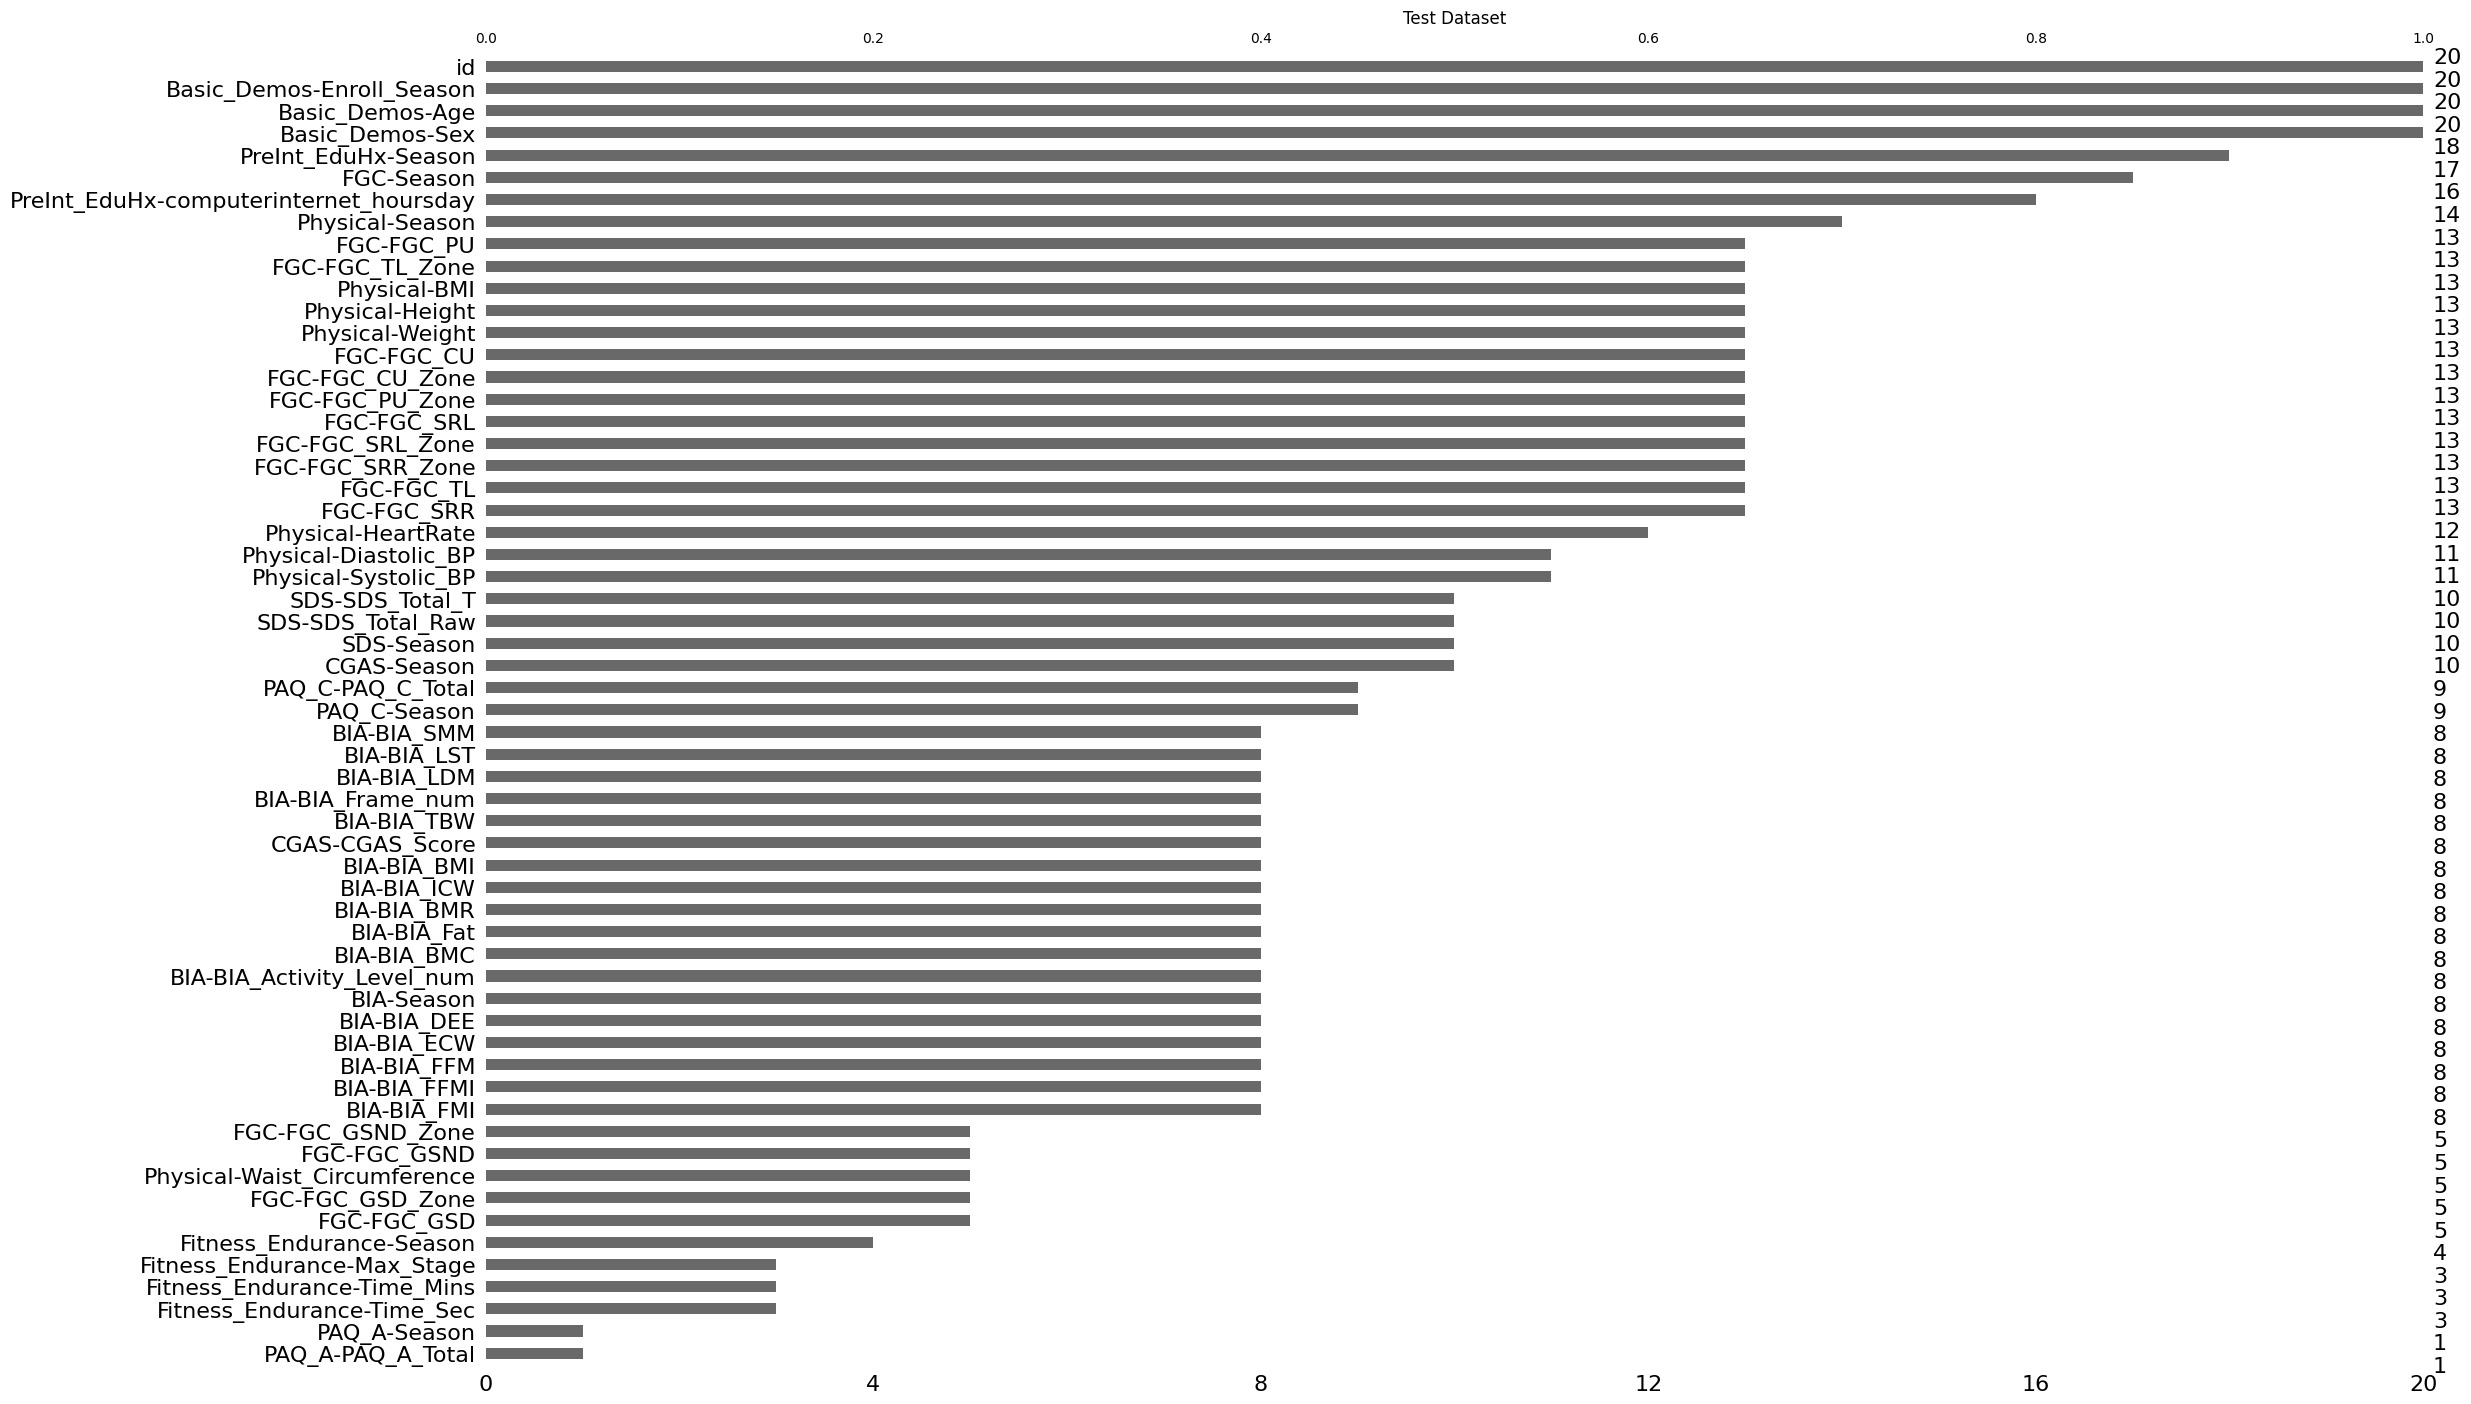

In [6]:
import missingno as msno
import matplotlib.pyplot as plt

# Create a bar plot for the training dataset
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
msno.bar(train.iloc[:, :train.shape[1]], sort='ascending')
plt.title("Train Dataset")
plt.show()

# Create a bar plot for the test dataset
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
msno.bar(test.iloc[:, :test.shape[1]], sort='ascending')
plt.title("Test Dataset")
plt.show()

In [7]:
#Các cột có ở trong tập train nhưng lại không có trong tập test
different_columns = set(train) - set(test)
different_columns

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [8]:
categorical_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
                      'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
                      'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

for col in categorical_columns:
    train[col] = train[col].astype('category')

categorical_unique_counts = {col: train[col].nunique() for col in categorical_columns}

categorical_summary = pd.DataFrame.from_dict(
    categorical_unique_counts, orient='index', columns=['Unique Value Count']
)
print(categorical_summary)



                           Unique Value Count
Basic_Demos-Enroll_Season                   4
CGAS-Season                                 4
Physical-Season                             4
Fitness_Endurance-Season                    4
FGC-Season                                  4
BIA-Season                                  4
PAQ_A-Season                                4
PAQ_C-Season                                4
SDS-Season                                  4
PreInt_EduHx-Season                         4


In [9]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


In [10]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]

train = train.dropna(subset='sii')

cat_cols = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
         'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
         'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

In [11]:
def handle_categorical_columns(df, cat_cols):
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype('category').cat.codes
    return df

train = handle_categorical_columns(train, cat_cols)
test = handle_categorical_columns(test, cat_cols)

In [12]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [13]:
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

In [14]:
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

X = train.drop(['sii'], axis=1)
y = train['sii']

In [15]:
def train_data(model_class, test_data, seed_list):
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=False)
    
    train_scores = []
    val_scores = []

    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        random_seed = np.random.choice(seed_list)

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = clone(model_class)
        if hasattr(model, 'random_state'):
            model.set_params(random_state=random_seed)

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[val_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_scores.append(train_kappa)
        val_scores.append(val_kappa)

        test_preds[:, fold] = model.predict(test_data)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Train : {np.mean(train_scores):.4f}")
    print(f"Validation : {np.mean(val_scores):.4f}")

    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') 
    assert KappaOptimizer.success, "Optimization did not converge."

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    tuned_kappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized : {Fore.CYAN}{Style.BRIGHT} {tuned_kappa:.3f}{Style.RESET_ALL}")

    test_preds_mean = test_preds.mean(axis=1)
    test_preds_tuned = threshold_Rounder(test_preds_mean, KappaOptimizer.x)

    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': test_preds_tuned
    })

    return submission

In [16]:
# from bayes_opt import BayesianOptimization
# import lightgbm as lgb

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# def lgb_eval(learning_rate, max_depth, num_leaves, min_data_in_leaf, feature_fraction,
#              bagging_fraction, lambda_l1, lambda_l2):
#     params = {
#         'learning_rate': learning_rate,
#         'max_depth': int(max_depth),
#         'num_leaves': int(num_leaves),
#         'min_data_in_leaf': int(min_data_in_leaf),
#         'feature_fraction': feature_fraction,
#         'bagging_fraction': bagging_fraction,
#         'lambda_l1': lambda_l1,
#         'lambda_l2': lambda_l2,
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbose': -1,
#     }

#     model = lgb.LGBMRegressor(**params, n_estimators=200)
#     model.fit(X_train, y_train)
#     y_val_pred = model.predict(X_val)

#     qwk = quadratic_weighted_kappa(y_val, y_val_pred.round())
#     return qwk

# param_bounds = {
#     'learning_rate': (0.01, 0.1),
#     'max_depth': (5, 15),
#     'num_leaves': (10, 50),
#     'min_data_in_leaf': (2, 10),
#     'feature_fraction': (0.6, 0.9),
#     'bagging_fraction': (0.6, 0.9),
#     'lambda_l1': (0.0, 0.5),
#     'lambda_l2': (0.0, 0.5),
# }

# optimizer = BayesianOptimization(f=lgb_eval, pbounds=param_bounds, random_state=42)

# optimizer.maximize(init_points=10, n_iter=500)

# lgb_best_params = optimizer.max['params']

# lgb_best_params['max_depth'] = int(lgb_best_params['max_depth'])
# lgb_best_params['num_leaves'] = int(lgb_best_params['num_leaves'])
# lgb_best_params['min_data_in_leaf'] = int(lgb_best_params['min_data_in_leaf'])

# print("Best Parameters after conversion:", lgb_best_params)

# final_model = lgb.LGBMRegressor(
#     learning_rate=lgb_best_params['learning_rate'],
#     max_depth=lgb_best_params['max_depth'],
#     num_leaves=lgb_best_params['num_leaves'],
#     min_data_in_leaf=lgb_best_params['min_data_in_leaf'],
#     feature_fraction=lgb_best_params['feature_fraction'],
#     bagging_fraction=lgb_best_params['bagging_fraction'],
#     lambda_l1=lgb_best_params['lambda_l1'],
#     lambda_l2=lgb_best_params['lambda_l2'],
#     n_estimators=200
# )

# final_model.fit(X_train, y_train)

In [17]:
# from bayes_opt import BayesianOptimization
# import xgboost as xgb

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# def xgb_eval(learning_rate, max_depth, min_child_weight, colsample_bytree, subsample, reg_alpha, reg_lambda):
#     params = {
#         'learning_rate': learning_rate,
#         'max_depth': int(max_depth),  # Chuyển đổi sang số nguyên
#         'min_child_weight': int(min_child_weight),
#         'colsample_bytree': colsample_bytree,
#         'subsample': subsample,
#         'reg_alpha': reg_alpha,
#         'reg_lambda': reg_lambda,
#         'objective': 'reg:squarederror',  # Tùy thuộc vào bài toán
#         'eval_metric': 'rmse',
#         'verbosity': 0,
#     }
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)
#     model = xgb.train(
#         params,
#         dtrain,
#         num_boost_round=200,
#         evals=[(dval, "validation")],
#         early_stopping_rounds=10,
#         verbose_eval=False
#     )
#     y_val_pred = model.predict(dval)
    
#     qwk = quadratic_weighted_kappa(y_val, y_val_pred.round())
#     return qwk

# param_bounds = {
#     'learning_rate': (0.01, 0.1),
#     'max_depth': (2, 15),
#     'min_child_weight': (1, 10),
#     'colsample_bytree': (0.6, 1.0),
#     'subsample': (0.6, 1.0),
#     'reg_alpha': (0.0, 0.5),
#     'reg_lambda': (0.0, 0.5),
# }

# optimizer = BayesianOptimization(f=xgb_eval, pbounds=param_bounds, random_state=42)

# optimizer.maximize(init_points=10, n_iter=500)

# xgb_best_params = optimizer.max['params']

# xgb_best_params['max_depth'] = int(xgb_best_params['max_depth'])
# xgb_best_params['min_child_weight'] = int(xgb_best_params['min_child_weight'])

# print("Best Parameters after conversion:", best_params)

# final_model = xgb.train(
#     params={
#         'learning_rate': xgb_best_params['learning_rate'],
#         'max_depth': xgb_best_params['max_depth'],
#         'min_child_weight': xgb_best_params['min_child_weight'],
#         'colsample_bytree': xgb_best_params['colsample_bytree'],
#         'subsample': xgb_best_params['subsample'],
#         'reg_alpha': xgb_best_params['reg_alpha'],
#         'reg_lambda': xgb_best_params['reg_lambda'],
#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse',
#         'verbosity': 0,
#     },
#     dtrain=xgb.DMatrix(X_train, label=y_train),
#     num_boost_round=200
# )

# final_model.fit(X_train, y_train)


In [18]:
# import catboost as cat
# from bayes_opt import BayesianOptimization

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# def catboost_eval(learning_rate, depth, l2_leaf_reg, bagging_temperature):
#     params = {
#         'learning_rate': learning_rate,
#         'depth': int(depth),
#         'l2_leaf_reg': l2_leaf_reg,
#         'bagging_temperature': bagging_temperature,
#         'loss_function': 'RMSE',
#         'eval_metric': 'RMSE',
#         'verbose': 0,
#     }
#     model = cat.CatBoostRegressor(**params, iterations=200)
#     model.fit(
#         X_train, y_train,
#         eval_set=(X_val, y_val),
#         early_stopping_rounds=10,
#         verbose=False
#     )
#     y_val_pred = model.predict(X_val)
    
#     qwk = quadratic_weighted_kappa(y_val, y_val_pred.round())
#     return qwk

# param_bounds = {
#     'learning_rate': (0.01, 0.1),
#     'depth': (2, 12),
#     'l2_leaf_reg': (1, 10),
#     'bagging_temperature': (0.0, 1.0),
# }

# optimizer = BayesianOptimization(f=catboost_eval, pbounds=param_bounds, random_state=42)

# optimizer.maximize(init_points=10, n_iter=500)

# cat_best_params = optimizer.max['params']

# cat_best_params['depth'] = int(cat_best_params['depth'])

# print("Best Parameters after conversion:", cat_best_params)

# final_model = cat.CatBoostRegressor(
#     learning_rate=cat_best_params['learning_rate'],
#     depth=cat_best_params['depth'],
#     l2_leaf_reg=cat_best_params['l2_leaf_reg'],
#     bagging_temperature=cat_best_params['bagging_temperature'],
#     iterations=200,
#     verbose=0
# )

# final_model.fit(
#     X_train, y_train,
#     eval_set=(X_val, y_val),
#     early_stopping_rounds=10,
#     verbose=False
# )

# final_model.fit(X_train, y_train)


In [19]:
latest_params = {
    'learning_rate': 0.03755757104848504,
    'max_depth': 12,
    'num_leaves': 18,
    'min_data_in_leaf': 3,
    'feature_fraction': 0.723690362968002,
    'bagging_fraction': 0.688232590484764,
    'bagging_freq': 5,
    'lambda_l1': 0.18512987285245963,
    'lambda_l2': 0.18435628737334625
}

# lgb_best_params = {
#    'learning_rate': 0.08357803130390955,
#    'max_depth': 10,
#    'num_leaves': 12,
#    'min_data_in_leaf': 2,
#    'feature_fraction': 0.8776100900448438,
#    'bagging_fraction': 0.8807042774329745,
#    'bagging_freq': 5,
#    'lambda_l1': 0.011306480671097408,
#    'lambda_l2': 0.41957967845856275
# }

# xgb_best_params = {
#     'colsample_bytree': 0.7228668416824718,
#     'learning_rate': 0.0531879347903598,
#     'max_depth': 5,
#     'min_child_weight': 8,
#     'reg_alpha': 0.3655460866477242,
#     'reg_lambda': 0.48749947194803767,
#     'subsample': 0.6437856777196495
# }

# cat_best_params = {
#     'bagging_temperature': 0.928800642588584,
#     'depth': 9,
#     'l2_leaf_reg': 6.791150013536176,
#     'learning_rate': 0.09641866532880425
# }

seed_list = [42]

In [20]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# lgb_model = lgb.LGBMClassifier(
#     learning_rate=lgb_best_params['learning_rate'],
#     max_depth=lgb_best_params['max_depth'],
#     num_leaves=lgb_best_params['num_leaves'],
#     min_data_in_leaf=lgb_best_params['min_data_in_leaf'],
#     feature_fraction=lgb_best_params['feature_fraction'],
#     bagging_fraction=lgb_best_params['bagging_fraction'],
#     lambda_l1=lgb_best_params['lambda_l1'],
#     lambda_l2=lgb_best_params['lambda_l2'],
#     n_estimators=200
# )

# xgb_model = xgb.XGBClassifier(
#     learning_rate=xgb_best_params['learning_rate'],
#     max_depth=xgb_best_params['max_depth'],
#     min_child_weight=xgb_best_params['min_child_weight'],
#     colsample_bytree=xgb_best_params['colsample_bytree'],
#     subsample=xgb_best_params['subsample'],
#     reg_alpha=xgb_best_params['reg_alpha'],
#     reg_lambda=xgb_best_params['reg_lambda'],
#     n_estimators=200
# )

# cat_model = cat.CatBoostClassifier(
#     learning_rate=cat_best_params['learning_rate'],
#     depth=cat_best_params['depth'],
#     l2_leaf_reg=cat_best_params['l2_leaf_reg'],
#     bagging_temperature=cat_best_params['bagging_temperature'],
#     loss_function='MultiClass',
#     eval_metric='MultiClass',
#     iterations=200,
#     verbose=0
# )

# # Tạo mô hình VotingClassifier
# voting_model = VotingClassifier(
#     estimators=[
#         ('lgb', lgb_model),
#         ('xgb', xgb_model),
#         ('cat', cat_model)
#     ],
#     voting='soft'
# )

# voting_model.fit(X_train, y_train)

# # Dự đoán trên tập kiểm tra
# y_pred = voting_model.predict(X_val)

# kappa = quadratic_weighted_kappa(y_val, y_pred)
# print(f'Voting Classifier Quadratic Weighted Kappa: {kappa:.4f}')

In [21]:
light_gbm_model = lgb.LGBMRegressor(**latest_params, verbose=-1, n_estimators=200)

submission_estimator = train_data(light_gbm_model, test, seed_list)

Training Folds: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]

Train : 0.7839
Validation : 0.3826


----> || Optimized :  0.443


In [22]:
# xgb_model = xgb.XGBRegressor(**xgb_best_params, verbose=0, n_estimators=200)

# submission_estimator = train_data(xgb_model, test, seed_list)

In [23]:
# cat_model = cat.CatBoostRegressor(**cat_best_params, verbose=0, n_estimators=200)

# submission_estimator = train_data(cat_model, test, seed_list)

In [24]:
# submission_estimator = train_data(voting_model, test, seed_list)

In [25]:
submission_estimator.to_csv('submission.csv', index=False)